In [3]:
import sys
# Use fast installs; in Colab you can uncomment the pip calls and run the cell
INSTALL = True
if INSTALL:
    !pip -q install moviepy librosa soundfile matplotlib opencv-python-headless tqdm transformers>=4.36.0 accelerate>=0.21.0 sentencepiece huggingface-hub>=0.20.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.17.1 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.17.3 which is incompatible.


In [4]:
import os
import math
import json
import tempfile
import numpy as np
import pandas as pd
from moviepy.editor import VideoFileClip
import librosa
import soundfile as sf
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import pipeline
import requests

# Helper: download a file from URL (if wanted)
from urllib.parse import urlparse

def download_url(url, target_path):
    r = requests.get(url, stream=True)
    r.raise_for_status()
    total = int(r.headers.get('content-length', 0))
    with open(target_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    return target_path



  _torch_pytree._register_pytree_node(

  _torch_pytree._register_pytree_node(



In [29]:
# You can either upload your own file in Colab or set VIDEO_PATH to a public URL.
# If using upload, leave VIDEO_PATH as None and use the upload helper below.
VIDEO_PATH = None
TARGET_FPS = 2    # frames per second to sample for motion analysis (low to be lightweight)
SEGMENT_SECONDS = 5  # segment duration for per-segment analysis
HIGHLIGHT_SECONDS = 10  # length of highlight clip to extract
MOTION_WEIGHT = 0.6
AUDIO_WEIGHT = 0.4

os.makedirs('outputs', exist_ok=True)

In [30]:
# If running in Colab, uncomment the following cell to upload a file with a file-picker.
try:
    from google.colab import files
    _IN_COLAB = True
except Exception:
    _IN_COLAB = False

if _IN_COLAB and VIDEO_PATH is None:
    print('Running in Colab. You can upload a video (30-60s) using the file-picker.')
    uploaded = files.upload()
    if len(uploaded) > 0:
        # take the first uploaded file
        VIDEO_PATH = list(uploaded.keys())[0]
        print('Uploaded:', VIDEO_PATH)

# If VIDEO_PATH is a remote URL, download it
if VIDEO_PATH and VIDEO_PATH.startswith('http'):
    print('Downloading video...')
    parsed = urlparse(VIDEO_PATH)
    filename = os.path.basename(parsed.path) or 'video.mp4'
    VIDEO_PATH = download_url(VIDEO_PATH, filename)
    print('Saved to', VIDEO_PATH)

if not VIDEO_PATH:
    raise SystemExit('No VIDEO_PATH provided. Upload a file in Colab or set VIDEO_PATH to a URL or path.')

# Quick sanity: load video metadata
clip = VideoFileClip(VIDEO_PATH)
VIDEO_DURATION = clip.duration
print(f'Loaded video: {VIDEO_PATH} — duration: {VIDEO_DURATION:.2f}s')
if VIDEO_DURATION < 8:
    print('Warning: video is shorter than 8s, behavior may be odd.')

Running in Colab. You can upload a video (30-60s) using the file-picker.


Saving Cristiano Ronaldo Celebration _ Loudest Crowd Roar!!.mp4 to Cristiano Ronaldo Celebration _ Loudest Crowd Roar!!.mp4
Uploaded: Cristiano Ronaldo Celebration _ Loudest Crowd Roar!!.mp4
Loaded video: Cristiano Ronaldo Celebration _ Loudest Crowd Roar!!.mp4 — duration: 22.00s


In [31]:
print('Extracting audio and computing audio energy...')
# Extract audio to temporary wav
audio_path = 'temp_audio.wav'
clip.audio.write_audiofile(audio_path, verbose=False, logger=None)

# Load audio with librosa (mono)
y, sr = librosa.load(audio_path, sr=None, mono=True)
# Compute RMS energy per short frame (hop length maps to 1 second windows)
hop_length = int(sr * 0.5)  # half-second hop
frame_length = int(sr * 0.5)  # compute RMS over 0.5s windows
rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
# Map RMS frames to times
rms_times = librosa.frames_to_time(range(len(rms)), sr=sr, hop_length=hop_length, n_fft=frame_length)
# For convenience, compute audio energy per 1-second bins aligned from 0..duration
bins = int(math.ceil(VIDEO_DURATION))
audio_energy = np.zeros(bins)
counts = np.zeros(bins)
for t_idx, t in enumerate(rms_times):
    bin_idx = min(int(t), bins - 1)
    audio_energy[bin_idx] += float(rms[t_idx])
    counts[bin_idx] += 1
for i in range(bins):
    if counts[i] > 0:
        audio_energy[i] /= counts[i]

# Normalize audio_energy to 0..1
if audio_energy.max() > 0:
    audio_energy = audio_energy / audio_energy.max()

print('Audio energy (per second):', audio_energy.shape)

Extracting audio and computing audio energy...
Audio energy (per second): (22,)


In [32]:
print('Computing visual motion energy (frame differencing)...')
# sample frames at TARGET_FPS and compute absolute difference between consecutive frames
video_cap = cv2.VideoCapture(VIDEO_PATH)
orig_fps = video_cap.get(cv2.CAP_PROP_FPS) or 25
frame_interval = int(round(orig_fps / TARGET_FPS)) if orig_fps > TARGET_FPS else 1
frame_count = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
frame_times = []
prev_gray = None
motion_energy_per_frame = []
frame_idx = 0
sampled_idx = 0
success = True
prog = tqdm(total=frame_count if frame_count>0 else int(VIDEO_DURATION*orig_fps))
while True:
    success, frame = video_cap.read()
    if not success:
        break
    if frame_idx % frame_interval == 0:
        # resize for speed
        h, w = frame.shape[:2]
        small = cv2.resize(frame, (w // 4, h // 4))
        gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)
        if prev_gray is not None:
            diff = cv2.absdiff(gray, prev_gray)
            motion_val = float(np.mean(diff))  # average pixel difference
        else:
            motion_val = 0.0
        motion_energy_per_frame.append(motion_val)
        frame_times.append(frame_idx / orig_fps)
        prev_gray = gray
        sampled_idx += 1
    frame_idx += 1
    prog.update(1)
video_cap.release()
prog.close()

# Map frame-level motion energy to per-second bins (same bins as audio)
motion_energy = np.zeros(bins)
counts = np.zeros(bins)
for t_idx, t in enumerate(frame_times):
    bin_idx = min(int(t), bins - 1)
    motion_energy[bin_idx] += motion_energy_per_frame[t_idx]
    counts[bin_idx] += 1
for i in range(bins):
    if counts[i] > 0:
        motion_energy[i] /= counts[i]
# Normalize
if motion_energy.max() > 0:
    motion_energy = motion_energy / motion_energy.max()

print('Motion energy (per second):', motion_energy.shape)

Computing visual motion energy (frame differencing)...


100%|█████████▉| 657/660 [00:01<00:00, 348.04it/s]

Motion energy (per second): (22,)


In [33]:
print('Combining audio + motion into unified energy...')
combined_energy = MOTION_WEIGHT * motion_energy + AUDIO_WEIGHT * audio_energy
# If audio or motion arrays are different length (should not be), pad
if len(combined_energy) < bins:
    combined_energy = np.pad(combined_energy, (0, bins - len(combined_energy)))

# Smooth a bit with moving average
def smooth(x, k=3):
    if len(x) < k:
        return x
    return np.convolve(x, np.ones(k)/k, mode='same')
combined_energy_smooth = smooth(combined_energy, k=3)

# Save a CSV with per-second energies
df = pd.DataFrame({
    'second': list(range(bins)),
    'audio_energy': audio_energy.tolist(),
    'motion_energy': motion_energy.tolist(),
    'combined_energy': combined_energy_smooth.tolist(),
})
df.to_csv('outputs/segments.csv', index=False)
print('Saved outputs/segments.csv')

Combining audio + motion into unified energy...
Saved outputs/segments.csv


In [34]:
print('Identifying low-energy moments...')
mean_e = float(np.mean(combined_energy_smooth))
std_e = float(np.std(combined_energy_smooth))
# low energy threshold: below mean - 0.35*std (tunable)
low_thresh = mean_e - 0.35 * std_e
low_indices = np.where(combined_energy_smooth < low_thresh)[0]

# Merge consecutive low seconds into contiguous low-energy segments
low_segments = []
if len(low_indices) > 0:
    start = low_indices[0]
    prev = low_indices[0]
    for idx in low_indices[1:]:
        if idx == prev + 1:
            prev = idx
            continue
        else:
            low_segments.append((start, prev + 1))
            start = idx
            prev = idx
    low_segments.append((start, prev + 1))

print('Detected low-energy segments (second ranges):', low_segments)

# Generate show cues using a T5-small text generation pipeline (lightweight)
print('Loading text generation model (this may take a moment)...')
text_gen = pipeline('text2text-generation', model='google/flan-t5-small', device_map='auto' if hasattr(__import__('os'), 'environ') else None)

show_cues = []
for (s, e) in low_segments:
    prompt = (
        f"You are a creative show designer. For a low-energy crowd moment from second {s} to {e} in a festival event or crowd gathered event,"
        " suggest one short, punchy show cue (7 words max) that the lighting or stage team can perform instantly."
    )
    out = text_gen(prompt, max_length=32, do_sample=True, top_p=0.9, num_return_sequences=1)[0]['generated_text']
    cue = out.strip().replace('\n', ' ')
    show_cues.append({'start': int(s), 'end': int(e), 'cue': cue})

# Save show cues
with open('outputs/show_cues.txt', 'w', encoding='utf-8') as f:
    for c in show_cues:
        f.write(f"{c['start']}-{c['end']}: {c['cue']}\n")

print('Saved outputs/show_cues.txt')

Identifying low-energy moments...
Detected low-energy segments (second ranges): [(np.int64(0), np.int64(6))]
Loading text generation model (this may take a moment)...
Saved outputs/show_cues.txt


Finding highest-energy 10-second window...
Best highlight window: 11s to 21s (score 6.300)
Saved highlight clip to outputs/highlight.mp4
Rendering timeline plot...


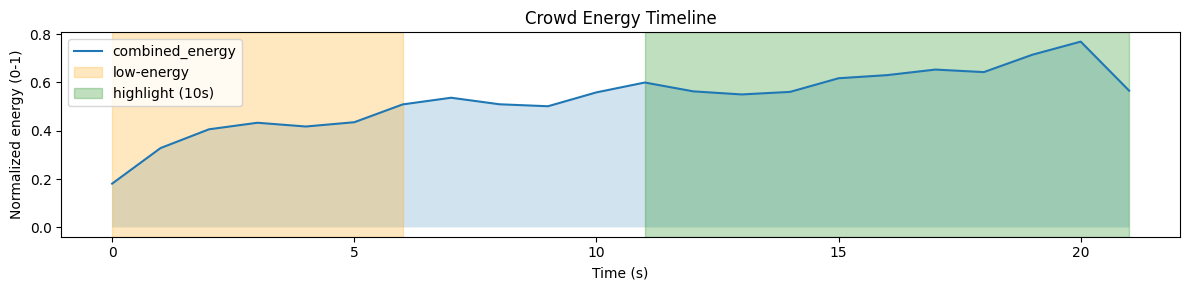

Saved outputs/energy_timeline.png


In [35]:
print('Finding highest-energy 10-second window...')
window = HIGHLIGHT_SECONDS
best_sum = -1
best_start = 0
for s in range(0, bins - window + 1):
    val = combined_energy_smooth[s:s+window].sum()
    if val > best_sum:
        best_sum = val
        best_start = s
best_end = best_start + window
print(f'Best highlight window: {best_start}s to {best_end}s (score {best_sum:.3f})')

# Extract highlight clip using moviepy
highlight_path = 'outputs/highlight.mp4'
start_t = float(best_start)
end_t = float(best_end)
subclip = clip.subclip(start_t, min(end_t, clip.duration))
# write out
subclip.write_videofile(highlight_path, codec='libx264', audio_codec='aac', verbose=False, logger=None)
print('Saved highlight clip to', highlight_path)
print('Rendering timeline plot...')
plt.figure(figsize=(12,3))
seconds = np.arange(len(combined_energy_smooth))
plt.plot(seconds, combined_energy_smooth, label='combined_energy')
plt.fill_between(seconds, 0, combined_energy_smooth, alpha=0.2)
# mark low segments
for (s,e) in low_segments:
    plt.axvspan(s, e, color='orange', alpha=0.25, label='low-energy' if s==low_segments[0][0] else '')
# mark highlight
plt.axvspan(best_start, best_end, color='green', alpha=0.25, label='highlight (10s)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Normalized energy (0-1)')
plt.title('Crowd Energy Timeline')
plt.tight_layout()
plt.savefig('outputs/energy_timeline.png', dpi=150)
plt.show()
print('Saved outputs/energy_timeline.png')
